1. Preprocess: 8:2 train test 셋 분리 -> categorical data 숫자형으로 encoding -> 학습에 관련 없는 칼럼 제거

2. Model Definision: Hyper parameter 지정

3. Training: XGBoost 사용

4. Evaluation: Stratified K-fold CV로 XGBoost 교차검증 및 성능 상승

In [4]:
import os
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error, roc_auc_score
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from joblib import dump, load
import xgboost as xgb
from sklearn.metrics import roc_auc_score
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import enum
import math
import shap
shap.initjs()

import warnings
warnings.filterwarnings('ignore')

In [5]:
def random_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

<h2>1. 데이터 셋 준비 및 preprocessing </h2>

In [9]:
data = pd.read_csv('MCHAT.csv')
data = data.drop(['InspectDate',
                    '1st_Screening_ASD_Criteria', 
                    'Congenital_Genetic_Disorder',
                    'History_of_Brain_Damage', 
                    'Seizure_or_Neurological_disease',
                    'SurveyApplicableMonthAge', 
                    'Total_Score', ], axis = 1)

# https://github.com/skwgbobf/ASD_Kaggle/blob/main/4.Kaggle1_%20BERT%20Classification.ipynb

# train test 8:2로 나눕니다.
np.random.seed(112)
train, test= np.split(data.sample(frac=1, random_state=42), 
                                     [int(.8*len(data))])

print(len(train), len(test))

114 29


In [10]:
# 2. Preprocess

# Categorical Data 숫자형으로 변환

# 데이터 칼럼 추출
cat_cols = list(train.select_dtypes('object').columns.values)

# 전처리 과정을 위해서 train과 test 셋들을 잠시 합칩니다.
df = pd.concat([train, test], axis=0)

# 데이터 타입을 모두 숫자형으로 통일
label_encoder = preprocessing.LabelEncoder()
for col in cat_cols:
    df[col]= label_encoder.fit_transform(df[col])

# train test를 다시 8:2로 나눕니다

train = df.iloc[:train.shape[0], :]
test = df.iloc[train.shape[0]:, :]

# 학습에 사용될 칼럼들 구별
columns = [col for col in train.columns if col not in ['Subject_Id', 
                                                       'Class/ASD'] ]

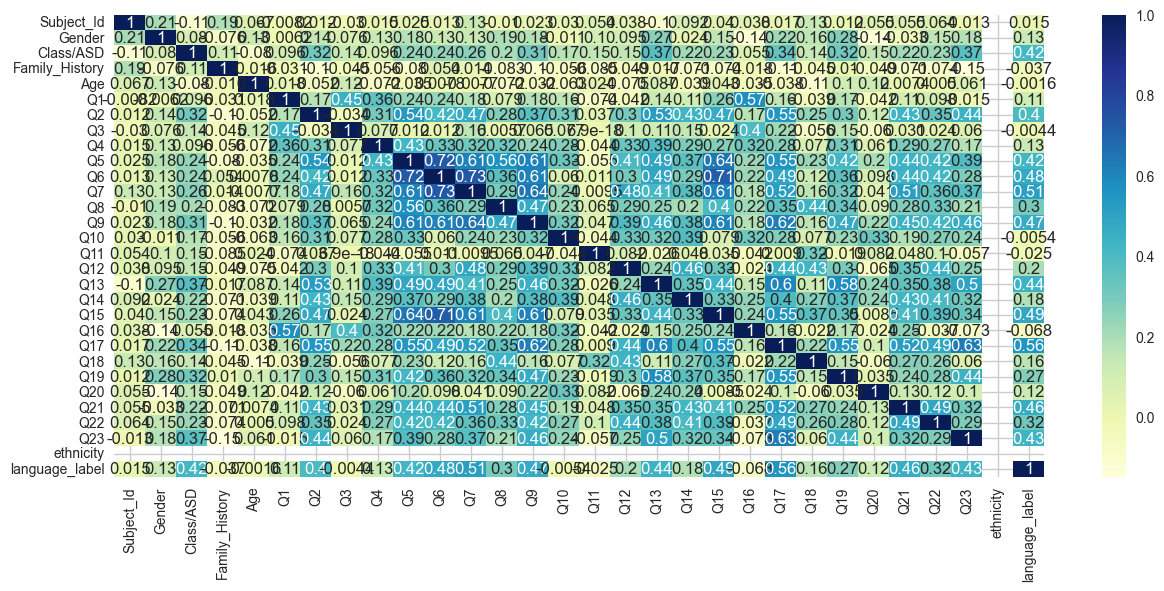

In [11]:
plt.rcParams["figure.figsize"] = (15,6)
dataplot = sns.heatmap(train.corr(), cmap="YlGnBu", annot=True)
plt.show()

<h2>2. Model Definition and Training </h2>

In [12]:
#xgboost 파라미터 값 설정

xgb_params=  {'learning_rate': 0.002,
              'objective': 'binary:logistic',
              'eval_metric': 'auc',
              'max_depth': 10,
              'alpha': 0.5108154566815425,
              'gamma': 1.9276236172849432,
              'reg_lambda': 11.40999855634382,
              'colsample_bytree': 0.705851334291963,
              'subsample': 0.8386116751473301,
              'min_child_weight': 2.5517043283716605,
}

In [13]:
# 시드값, CV fold 개수, 훈련 조기중단 변수 설정
class Config(enum.Enum):
    SEED = 42
    N_FOLDS = 5
    EARLY_STOP = 300

<h2>3. XGBoost and Stratified K-fold Cross-Validation </h2>

Stratified K-fold Cross Validation?

K-fold CV: 
 - Cross-Validation과 같은 방식
 - fold라고 불리는 각각의 data subset이 같은 양의 데이터 보유

Stratified K-fold CV:
 - K-fold CV와 같은 방식
 - 각각의 fold가 같은 비율의 target label을 가지고 있음

In [14]:
%%time

random_seed(Config.SEED.value)

auc_score = []

targets = train['Class/ASD'].values

# Stratified K-fold CV 환경변수 설정
kf = StratifiedKFold(n_splits = Config.N_FOLDS.value, shuffle=True, random_state=Config.SEED.value)    
        
oof = np.zeros((train.shape[0],))
test_preds = 0

# 5개의 fold를 이용해 XGBoost 모델 학습
for f, (train_idx, val_idx) in tqdm(enumerate(kf.split(X=train, y=targets))):
        # 학습이 끝날때마다 valiation 
        df_train, df_val = train.iloc[train_idx][columns], train.iloc[val_idx][columns]
        train_target, val_target = targets[train_idx], targets[val_idx]
        
        train_df = xgb.DMatrix(df_train, label=train_target)
        val_df = xgb.DMatrix(df_val, label=val_target)
        test_df = xgb.DMatrix(test[columns])
        watchlist  = [ (train_df,'train'),(val_df,'eval')]
        model =  xgb.train(
            xgb_params, # 하이퍼 파라미터 값 설정
            train_df, # 학습 데이터
            10000, # 10000번의 학습을 진행 
            watchlist, # evaluation에 사용할 데이터셋들
            early_stopping_rounds=Config.EARLY_STOP.value, # train과 eval set에 대한 accuracy가 300 iterations동안 상승하지 않을 시에 학습을 종료합니다.
            verbose_eval=1000 # 1000번 학습할때마다 evaluation 결과 출력
        )
        
        # AUC 계산 
        oof_tmp = model.predict(val_df)
        test_tmp = model.predict(test_df)
        oof[val_idx] = oof_tmp
        test_preds += test_tmp/Config.N_FOLDS.value
        auc = roc_auc_score(val_target, oof_tmp)
        auc_score.append(auc)
        print(f'FOLD: {f} AUC: {auc} Mean AUC: {np.mean(auc_score)}')


0it [00:00, ?it/s]

[0]	train-auc:0.50000	eval-auc:0.50000
[625]	train-auc:0.84047	eval-auc:0.76471


1it [00:00,  4.68it/s]

FOLD: 0 AUC: 0.7647058823529411 Mean AUC: 0.7647058823529411
[0]	train-auc:0.50000	eval-auc:0.50000
[513]	train-auc:0.87980	eval-auc:0.80882


2it [00:00,  4.93it/s]

FOLD: 1 AUC: 0.8088235294117647 Mean AUC: 0.7867647058823529
[0]	train-auc:0.50000	eval-auc:0.50000
[562]	train-auc:0.82353	eval-auc:0.77451


3it [00:00,  5.25it/s]

FOLD: 2 AUC: 0.7745098039215687 Mean AUC: 0.7826797385620915
[0]	train-auc:0.50000	eval-auc:0.50000
[681]	train-auc:0.87788	eval-auc:0.82353


4it [00:00,  4.48it/s]

FOLD: 3 AUC: 0.8235294117647058 Mean AUC: 0.7928921568627452
[0]	train-auc:0.50000	eval-auc:0.50000
[965]	train-auc:0.86091	eval-auc:0.88235


5it [00:01,  3.82it/s]

FOLD: 4 AUC: 0.8823529411764706 Mean AUC: 0.8107843137254903
CPU times: user 6.53 s, sys: 9.93 s, total: 16.5 s
Wall time: 1.33 s


In [15]:
%%time
shap_preds = model.predict(test_df, pred_contribs=True)

CPU times: user 6.47 ms, sys: 2.86 ms, total: 9.32 ms
Wall time: 3.62 ms


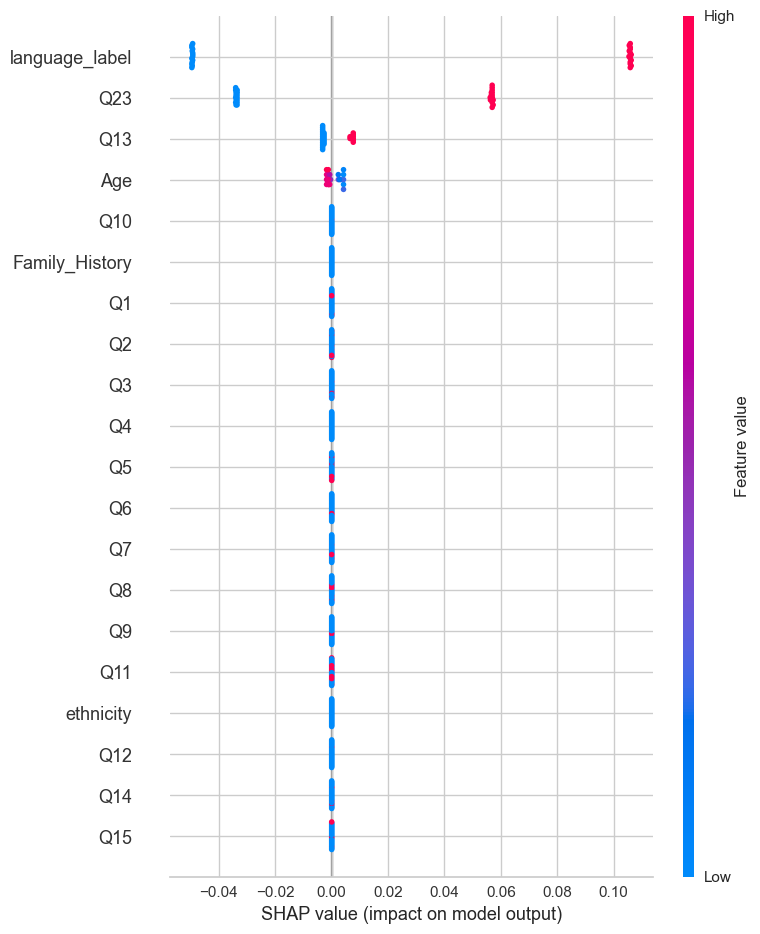

In [16]:
shap.summary_plot(shap_preds[:, :-1], test[columns])

In [17]:
test['predicted_score'] = test_preds
test.to_csv('submission.csv', index=False)

In [18]:
constant_prediction = []

for i in range(len(test_preds)):
    if test_preds[i] < 0.5:
        constant_prediction.append(0)
    else:
        constant_prediction.append(1)

# 학습된 모델로 테스트 셋 예측 결과

# Calculate the number of matches
assert len(test['Class/ASD']) == len(constant_prediction)

matches = test['Class/ASD'] == constant_prediction

num_matches = matches.sum()

# Calculate the matching percentage
matching_percentage = (num_matches / len(constant_prediction)) * 100

<h2>AUC return</h2>

In [19]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import matplotlib.pyplot as plt

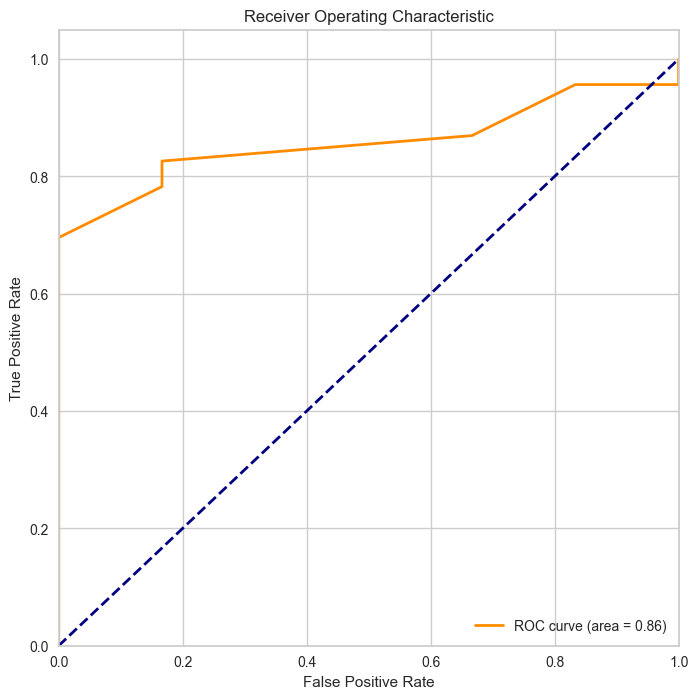

In [20]:
true_labels = test['Class/ASD']

fpr, tpr, _ = roc_curve(true_labels, test_preds) # False positive, True positivee rate
roc_aucs = auc(fpr, tpr) # AUC result

# Plot the ROC curve
plt.figure(figsize=(8, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_aucs)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

<h2>f1 score</h2>

In [21]:
from sklearn.metrics import f1_score

true_labels = test['Class/ASD'].values
f1 = f1_score(true_labels, constant_prediction)

In [22]:
print(f"Accuracy: {matching_percentage:.2f}%")
print("Mean AUC: ", roc_aucs)
print("F1 Score:", f1)

Accuracy: 79.31%
Mean AUC:  0.858695652173913
F1 Score: 0.8846153846153846


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

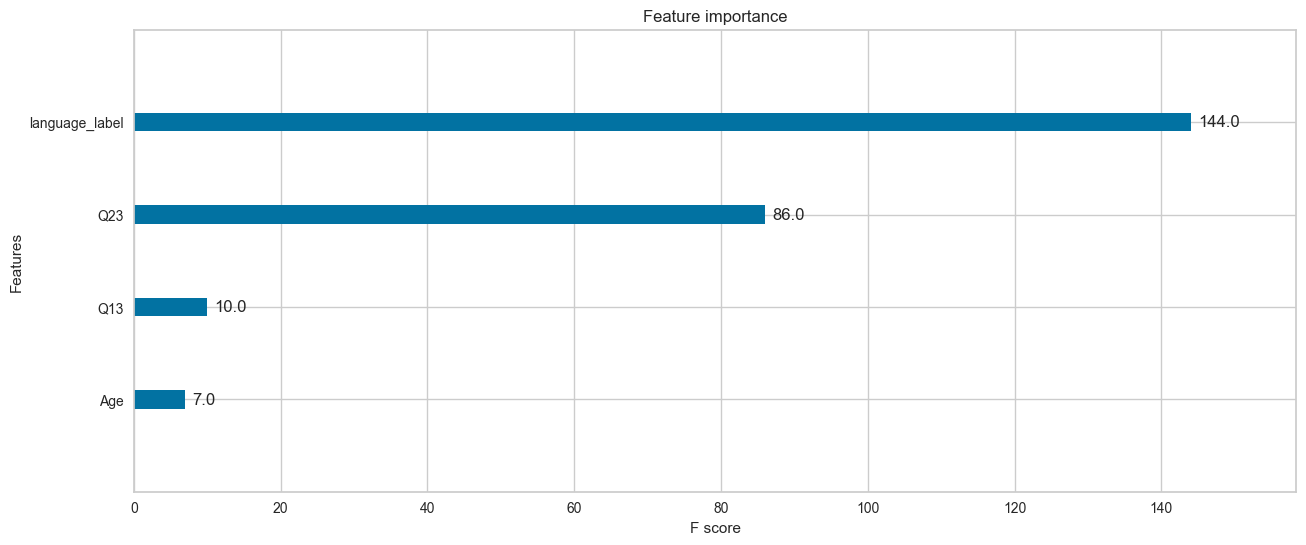

In [48]:
xgb.plot_importance(model)

In [46]:
import joblib
joblib.dump(model, open('output', 'wb'))
temp = load(open('output', 'rb'))